Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE" and remove every line containing the expression: "raise ..." (if you leave such a line your code will not run).

## IMPORTANT: make sure to rerun all the code from the beginning to obtain the results for the final version of your notebook, since this is the way we will do it before evaluating your notebook!!!

Fill in your name and id number (numero matricola) below:

In [67]:
NAME = "Jacopo Andreoli"
ID_number = int("2011655")

---

# Linear Regression  on a Combined Cycle Power Plant (CCPP) data


## Dataset description

The dataset contains 5281 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (EP)  of the plant.

A combined cycle power plant (CCPP) is composed of gas turbines (GT), steam turbines (ST) and heat recovery steam generators. In a CCPP, the electricity is generated by gas and steam turbines, which are combined in one cycle, and is transferred from one turbine to another. While the Vacuum has effect on the Steam Turbine, the other three of the ambient variables effect the GT performance.

In [69]:
from __future__ import division  
# to get in-line plots
%matplotlib nbagg
import matplotlib.pyplot as plt
   
import numpy as np
import scipy as sp
from scipy import stats

In [70]:
import pandas as pd

In [71]:
## Import Data
# Load the data from a .csv file

np.random.seed(ID_number)

filename = "ccpp_Data_clean2018.csv"

data = np.genfromtxt(filename, delimiter=';',skip_header=1) #AT	V	AP	RH	PE  
#Ambient temperature   Exhaust Vacuum   Ambient pressure   Relative Humidity   Energy output 


         AT      V       AP     RH      PE
0     23.97  63.86  1018.09  57.62  441.65
1     20.63  43.77  1010.71  62.34  448.25
2     23.63  73.18  1012.29  88.81  437.70
3     24.84  71.73  1009.84  82.41  436.36
4     25.76  71.06  1007.93  90.40  433.75
...     ...    ...      ...    ...     ...
5276  11.76  41.58  1020.91  88.35  465.45
5277  14.02  40.10  1015.56  82.44  467.32
5278  16.65  49.69  1014.01  91.00  460.03
5279  13.19  39.18  1023.67  66.78  469.62
5280  31.32  74.33  1012.92  36.48  429.57

[5281 rows x 5 columns]


<IPython.core.display.Javascript object>


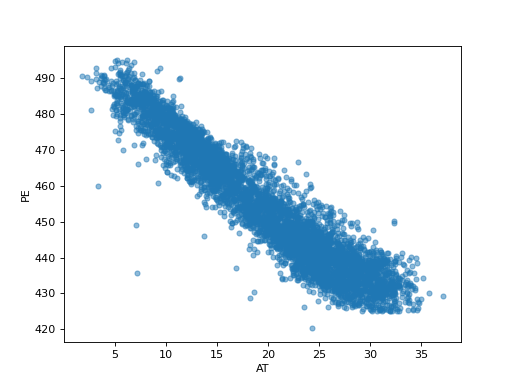

In [72]:
data_pd=pd.read_table(filename, delimiter=';')
print(data_pd)
data_pd.plot.scatter(x='AT', y='PE', alpha=0.5)

# A quick overview of data

To inspect the data you can use the method describe()

In [75]:
dataDescription = stats.describe(data)
print(dataDescription)

data.shape

#for more interesting visualization: use Panda!

DescribeResult(nobs=5281, minmax=(array([  1.81,  25.36, 992.89,  25.56, 420.26]), array([  37.11,   81.56, 1033.29,  100.16,  495.23])), mean=array([  19.67317553,   54.31940163, 1013.22432115,   73.38815187,
        454.31701004]), variance=array([ 56.0327041 , 161.7733201 ,  35.2083789 , 217.43618617,
       291.84459771]), skewness=array([-0.13713412,  0.19522075,  0.24934713, -0.43467097,  0.29846615]), kurtosis=array([-1.04662553, -1.45165813,  0.01128758, -0.43044229, -1.05785395]))


(5281, 5)

# Split data in training, validation and test sets



Given $m$ total data, keep $m_t$ data as training data, $m_{val}:=m_{tv}-m_t$ as validation data and $m_{test}:=m - m_{val} - m_t = m-m_{tv}$. For instance one can take $m_t=m/3$ of the data as training, $m_{val}=m/3$  validation and $m_{test}=m/3$ as testing. Let us define as define

$\bullet$ $S_{t}$ the training data set

$\bullet$ $S_{val}$ the validation data set

$\bullet$ $S_{test}$ the testing data set


The reason for this splitting is as follows:

__TRAINING DATA__: The training data are used to compute the empirical loss
$$
L_S(h) = \frac{1}{m_t} \sum_{z_i \in S_{t}} \ell(h,z_i)
$$
which is used to estimate $\hat{h}$ (ERM) in a given model class ${\cal H}$.
i.e. 
$$
\hat{h} = {\rm arg\; min}_{h \in {\cal H}} \, L_S(h)
$$

__VALIDATION DATA__: When different model classes are present (e.g. of different complexity such as linear regression which uses a different number $d_j$ of regressors $x_1$,...,$x_{d_j}$), one has to choose which one is the "best" complexity. 
Let ${\cal H}_{d_j}$ be the space of models as a function of the complexity $d_j$ and let 
$$
\hat h_{d_j} = {\rm arg\; min}_{h \in {\cal H}_{d_j}} \, L_S(h)
$$

One can estimate the generalization error for model $\hat h_{d_j}$ as follows:
$$
L_{{\cal D}}(\hat h_{d_j}) \simeq \frac{1}{m_{val}} \sum_{ z_i \in S_{val}} \ell(\hat h_{d_j},z_i)
$$
and then choose the complexity which achieves the best estimate of the generalization error
$$
\hat d_j: = {\rm arg\; min}_{d_j} \,\frac{1}{m_{val}} \sum_{ z_i \in S_{val}} \ell(\hat h_{d_j},z_i)
$$

__TESTING DATA__: Last, the test data set can be used to estimate the performance of the final estimated model
$\hat h_{\hat d_j}$ using:
$$
L_{{\cal D}}(\hat h_{\hat d_j}) \simeq \frac{1}{m_{test}} \sum_{ z_i \in S_{test}} \ell(\hat h_{\hat d_j},z_i)
$$

In [76]:
# TODO 1
# Write a function which takes as input a dataset and returns 3 datasets: S_t, S_val, S_test.
# Each dataset is represented as a matrix m \times d (numpy ndarray), where m is the number of data and d is the 
# number of features.
def create_train_val_test_datasets(data : np.ndarray, m_t : int, m_val : int, m_test : int):
    '''
    Create training (S_t), validation (S_val) and test (S_test) sets starting from a dataset. 
    This function shuffles the complete dataset before creating the subsets. If you call this function twice it is 
    expected to get different S_t, S_val, S_test.
    
    :param data: NumPy ndarray containing all the data we can use
    :param m_t: Number of samples for the training dataset
    :param m_val: Number of samples for the validation dataset
    :param m_test: Number of samples for the test dataset
    
    :returns: (S_t, S_val, S_test)
    :rtype: tuple
        WHERE
        S_t : np.ndarray is the training dataset
        S_val : np.ndarray is the validation dataset
        S_test : np.ndarray is the test dataset
    '''
    # SUGGESTION: Use the function np.random.permutation (see the documentation) to create a permutation of the 
    #             dataset indexes. Then use these shuffled indexes to create S_t, S_val, S_test
    # YOUR CODE HERE
    S_t=np.zeros((m_t, 5))
    S_test=np.zeros((m_test, 5))
    S_val=np.zeros((m_val, 5))
    data=np.random.permutation(data)
    for i in range(m_t):
         S_t[i]=data[i]
    for i in range(m_val):
         S_val[i]=data[i+m_t]
    for i in range(m_test):
        S_test[i]=data[i+m_t+m_val]
    return S_t, S_val, S_test

Let's split the data in training, validation and test sets (suggestion: use $m_t=m_{val} = \lfloor\frac{m}{3}\rfloor$, $m_{test} = m-m_t-m_{val}$)

In [77]:
# Let's split the data into 3 datasets
m = data.shape[0]
m_t, m_val = m // 3, m // 3
m_test = m - m_t - m_val
S_t, S_val, S_test = create_train_val_test_datasets(data, m_t, m_val, m_test)

In [78]:
assert S_t.shape    == (m_t,    data.shape[1]) # here we are comparing two tuples (it is an element wise comparison)
assert S_val.shape  == (m_val,  data.shape[1])
assert S_test.shape == (m_test, data.shape[1])

In [79]:
# Now we get input data (X) and output data (y, variable to be predicted) from S_t, S_val, S_test 
x_train, y_train = S_t[:,:-1],    S_t[:,-1].reshape(-1,1) # We use reshape so that we will get a column vector
x_val,   y_val   = S_val[:,:-1],  S_val[:,-1].reshape(-1,1)
x_test,  y_test  = S_test[:,:-1], S_test[:,-1].reshape(-1,1)
print(f"Training input data size:    {x_train.shape}")
print(f"Training output data size:   {y_train.shape}")
print(f"Validation input data size:  {x_val.shape}")
print(f"Validation output data size: {y_val.shape}")
print(f"Test input data size:        {x_test.shape}")
print(f"Test output data size:       {y_test.shape}")

Training input data size:    (1760, 4)
Training output data size:   (1760, 1)
Validation input data size:  (1760, 4)
Validation output data size: (1760, 1)
Test input data size:        (1761, 4)
Test output data size:       (1761, 1)


# Data Normalization

It is common practice in Statistics and Machine Learning to scale the data (= each variable) so that it is centered (zero mean) and has standard deviation equal to $1$. This helps in terms of numerical conditioning of the (inverse) problems of estimating the model (the coefficients of the linear regression in this case), as well as to give the same scale to all the coefficients. 

NOTE: Data normalization is achieved by means of a preprocessing function: the scaler. 
If you want to normalize you data to have zero (empirical) mean and unit (empirical) variance the scaler will simply be a function that takes each data point, remove the empirical mean and then divide the result by the empirical variance. In this way you get a new normalized dataset. 

NORMALIZATION and TRAINING PROCEDURE:

$\bullet$ $1$ You are given a training dataset, you need to find the proper scaler in order to preprocess it (e.g. use empirical mean and variance, if you want to apply the normalization by mean and variance, you could also use a different normalization for example based on the max and min) 

$\bullet$ $2$ Apply the scaler to get the preprocessed training dataset 

$\bullet$ $3$ Fit a model in your preferred class on the normalized dataset

$\bullet$ $4$ Now you need to test your trained model on new data in order to get an estimate of the generalization error. Note you have trained you model using normalized data, this means that the model expects data that have been normalized (according to the same preprocessing step as the training data). This means that you need to apply the same scaler (that exploits the empirical mean and variance computed from the training dataset) to the test dataset (the same holds true for the validation dataset).

See next cell (note that the mean and std for the validation and test sets are not 0 and 1 respectively!)

__Remark__: Both input x and output y can be normalized!

In [80]:
# Let's standardize the our data in this case we only standardize input data X
from sklearn import preprocessing
# Find the right scaler (we are allowed to use only training data in this step)
scaler = preprocessing.StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
print(f"Mean of the training input data:   {x_train.mean(axis=0)}")
print(f"Std of the training input data:    {x_train.std(axis=0)}")
# Apply the tranformation we got with the training dataset both to the validation and test ones
x_val = scaler.transform(x_val) # use the same transformation on validation data
print(f"Mean of the validation input data: {x_val.mean(axis=0)}")
print(f"Std of the validation input data:  {x_val.std(axis=0)}")
x_test = scaler.transform(x_test) # use the same transformation on test data
print(f"Mean of the test input data:       {x_test.mean(axis=0)}")
print(f"Std of the test input data:        {x_test.std(axis=0)}")

Mean of the training input data:   [ 3.05601504e-15  1.86492236e-15 -6.96011430e-14 -2.73266258e-16]
Std of the training input data:    [1. 1. 1. 1.]
Mean of the validation input data: [-0.00648499  0.00114516 -0.00867013 -0.00591391]
Std of the validation input data:  [1.01794308 1.01107008 1.00697409 1.01865956]
Mean of the test input data:       [-0.02668518  0.00103595  0.00748188  0.02501582]
Std of the test input data:        [1.01258274 0.99029601 0.94569588 1.00394432]


In [81]:
# Let's wrap the code above in single function since we will need it many times
def data_preprocessing(train_data : np.ndarray, val_data : np.ndarray, test_data : np.ndarray, scaler): 
    '''
    Function used to scale data (train, validation, test) using a tranformation based on training data. 
    This function returns also the fitted scaler, since we will need it in order to tranform other future data.
    
    :param train_data: NumPy ndarray containing the train data we can use
    :param val_data: NumPy ndarray containing the validation data
    :param test_data: NumPy ndarray containing the test data
    :param scaler: Scaler from sklearn.preprocessing
    
    :returns:  (scaled_train_data, scaled_val_data, scaled_test_data, fitted_scaler)
    :rtype: tuple
        WHERE
        scaled_train_data: np.ndarray scaled train data
        scaled_val_data: np.ndarray scaled validation data
        scaled_test_data: np.ndarray scaled test data
        fitted_scaler: fitted scaler
    '''
    fitted_scaler = scaler.fit(train_data)
    return (fitted_scaler.transform(train_data), fitted_scaler.transform(val_data), 
            fitted_scaler.transform(test_data), fitted_scaler)

# Let's normalize also the output data
y_train, y_val, y_test, y_fitted_scaler = data_preprocessing(train_data=y_train, val_data=y_val, test_data=y_test, 
                                                             scaler=preprocessing.StandardScaler())
print(f"Mean of the training output data:   {y_train.mean(axis=0)}")
print(f"Std of the training output data:    {y_train.std(axis=0)}")
print(f"Mean of the validation output data: {y_val.mean(axis=0)}")
print(f"Std of the validation output data:  {y_val.std(axis=0)}")
print(f"Mean of the test output data:       {y_test.mean(axis=0)}")
print(f"Std of the test output data:        {y_test.std(axis=0)}")

Mean of the training output data:   [5.95483259e-17]
Std of the training output data:    [1.]
Mean of the validation output data: [0.00030557]
Std of the validation output data:  [1.0147682]
Mean of the test output data:       [0.01365746]
Std of the test output data:        [1.01370493]


In [82]:
def data_splitting_and_preprocessing(data : np.ndarray, m_t : int, m_val : int, m_test : int, 
                                     input_scaler, output_scaler):
    '''
    Perform in single call all the preprocessing we have done so far!
    
    :param data: NumPy ndarray containing all the data we can use
    :param m_t: Number of samples for the training dataset
    :param m_val: Number of samples for the validation dataset
    :param m_test: Number of samples for the test dataset
    :param input_scaler: Scaler from sklearn.preprocessing to be applied to the inputs
    :param output_scaler: Scaler from sklearn.preprocessing to be applied to the outputs
    
    :returns: (x_train, y_train, x_val, y_val, x_test, y_test, fitted_I_scaler, fitted_O_scaler)
    :rtype: tuple
        WHERE
        x_train : np.ndarray is the scaled input training dataset
        y_train : np.ndarray is the scaled output training dataset
        x_val : np.ndarray is the scaled input validation dataset
        y_val : np.ndarray is the scaled output validation dataset
        x_test : np.ndarray is the scaled input test dataset
        y_test : np.ndarray is the scaled output test dataset
        fitted_I_scaler : fitted scaler to the inputs
        fitted_O_scaler : fitted scaler to the outputs
    '''
    # Create training, validation, test datasets
    S_t, S_val, S_test = create_train_val_test_datasets(data=data, m_t=m_t, m_val=m_val, m_test=m_test)
    # Split datasets in input (x) and output (y)
    x_train, y_train = S_t[:,:-1],    S_t[:,-1].reshape(-1,1)
    x_val,   y_val   = S_val[:,:-1],  S_val[:,-1].reshape(-1,1)
    x_test,  y_test  = S_test[:,:-1], S_test[:,-1].reshape(-1,1)
    # Normalize input data (using a transformation based only on the training input data)
    x_train, x_val, x_test, fitted_I_scaler = data_preprocessing(train_data=x_train, val_data=x_val, test_data=x_test, 
                                                                 scaler=input_scaler)
    y_train, y_val, y_test, fitted_O_scaler = data_preprocessing(train_data=y_train, val_data=y_val, test_data=y_test, 
                                                                 scaler=output_scaler)
    return x_train, y_train, x_val, y_val, x_test, y_test, fitted_I_scaler, fitted_O_scaler

# Model Training 

The model is trained (= estimated) minimizing the empirical error
$$
L_S(h) := \frac{1}{m_t} \sum_{z_i \in S_{t}} \ell(h,z_i)
$$
When the loss function is the quadratic loss
$$
\ell(h,z) := (y - h(x))^2
$$
we define  the Residual Sum of Squares (RSS) as
$$
RSS(h):= \sum_{z_i \in S_{t}} \ell(h,z_i) = \sum_{z_i \in S_{t}} (y_i - h(x_i))^2
$$ so that the training error becomes
$$
L_S(h) = \frac{RSS(h)}{m_t}
$$

We recal that, for linear models with scalar output we have $h(x) = <w,x>$ and the Empirical error $L_S(h)$ can be written
in terms of the vector of parameters $w$ in the form
$$
L_S(w) = \frac{1}{m_t} \|Y - X w\|^2
$$
where $Y$ and $X$ are the matrices whose $i-$th row are, respectively, the output data $y_i$ and the input vectors $x_i^\top$.

The least squares solution is given by the expression
$$
\hat w = {\rm arg\;min}_w L_S(w) = (X^\top X)^{-1} X^\top Y
$$
When the matrix $X^\top X$ is not invertible, the solution can be computed using the Moore-Penrose pseudoinverse $(X^\top X)^{\dagger}$ of $(X^\top X)$
$$
\hat w = (X^\top X)^{\dagger} X^\top Y
$$
The Moore-Penrose pseudoinverse $A^\dagger$ of a matrix $A \in \mathbb{R}^{m\times n}$ can be expressed in terms of the Singular Value Decomposition (SVD) as follows:

Let $A\in \mathbb{R}^{m\times n}$ be of rank $r\leq {\rm min}(n,m)$ and let  
$$
 A = USV^\top
 $$
 be the singular value decomposition of  $A$ where  
 $$
 S = {\rm diag}\{s_1,s_2,..,s_r\}
 $$
 Then 
 $$
 A^\dagger =V S^{-1} U^\top 
 $$
 
 In practice some of the singular values may be very small (e.g. $<1e-12$). Therefore it makes sense to 
 first approximate the matrix $A$ truncating the SVD and then using the pseudoinverse formula.
 
 More specifically, let us postulate that, given a threshold $T_h$ (e.g $=1e-12$), we have $\sigma_i<T_h$, for $i=\hat r + 1,..,r$. Then we can approximate (by SVD truncation) $A$ using:
 
 $$A = USV^\top =U \,{\rm diag}\{s_1,s_2,..,s_r\}\, V^\top \simeq \hat A_r = U\,{\rm diag}\{s_1,s_2,..,s_{\hat r}, 0,..,0\}\,V^\top
 $$
 So that 
 $$
 A^\dagger \simeq \hat A_r^\dagger:= V \,{\rm diag}\{1/s_1,1/s_2,..,1/s_{\hat r}, 0,..,0\}\, U^\top
 $$

 ** TO DO **: compute the linear regression coefficients directly (using pseudo inverse) and using np.linalg.lstsq from scikitlearn

In [83]:
# TODO 2
# Create a function to compute the pseudo-inverse (as showed in the previous cell) of a general rectangular matrix 
def pseudoinverse(A : np.ndarray, threshold : float=1e-10) -> np.ndarray: # this cool rigth arrow is used to give info on the returned type
    '''
    Function to compute the pseudo-inverse of a general rectangular matrix.
    
    :param A: Matrix to be inverted
    :returns: Pseudo-inverse of A
    :rtype: np.ndarray (this line could be avoided since it is present in the function definition)
    '''
    # SUGGESTIONS: 
    # 1- Use np.linalg.svd to get the SVD (be carefull on the argument full_matrices)
    # 2- Have a look at np.where to perform the threshold and inverse of S
    # YOUR CODE HERE
    U_a, S_a, V_a=np.linalg.svd(A, full_matrices=False)
    for i in range(len(S_a)):
        S_a[i]=np.where(S_a[i]<threshold, 0, 1/S_a[i])
    A_pseudo_inverse=np.matmul(np.matmul(V_a.T, np.diag(S_a)), U_a.T)
    return A_pseudo_inverse

In [84]:
A, B, C = np.random.normal(size=(4,4)), np.random. normal(size=(3,5)), np.random.normal(size=(5,3))
assert np.isclose(np.abs(np.matmul(A, pseudoinverse(A)) - np.eye(A.shape[0])).sum(), 0., atol=1e-5)
assert np.isclose(np.abs(np.matmul(B, pseudoinverse(B)) - np.eye(B.shape[0])).sum(), 0., atol=1e-5)
assert np.isclose(np.abs(np.matmul(pseudoinverse(C), C) - np.eye(C.shape[1])).sum(), 0., atol=1e-5)

In [85]:
# Let's use a full rank matrix (A) and a rank deficient matrix (D) to better see the properties of the pseudo-inverse
A = np.array([1,2,3,2,11,7,10,5,9]).reshape(3,3)
D = np.array([1,2,3,2,4,6,10,5,9]).reshape(3,3)
A_inv, D_pinv = np.linalg.inv(A), pseudoinverse(D)

AA_inv, A_invA = np.matmul(A, A_inv), np.matmul(A_inv, A)
DD_pinv, D_pinvD = np.matmul(D, D_pinv), np.matmul(D_pinv, D)
print(f"We expect AA^(-1) = I_3:      \n {np.where(AA_inv > 1e-10, AA_inv, 0.)}")
print(f"We expect A^(-1)A = I_3:      \n {np.where(A_invA > 1e-10, A_invA, 0.)}")
print(f"We'd expect DD^\dagger = I_3: \n {np.where(DD_pinv > 1e-10, DD_pinv, 0.)}")
print(f"We'd expect D^\daggerD = I_3: \n {np.where(D_pinvD > 1e-10, D_pinvD, 0.)}")
# Let's deeper inspect previous relations 
AA_invA, AA_invA_2 = np.matmul(AA_inv, A), np.matmul(A, A_invA)
DD_pinvD, DD_pinvD_2 = np.matmul(DD_pinv, D), np.matmul(D, D_pinvD)
print(f"Since AA^(-1) = I_3 we can postmultiply by A and get AA^(-1)A = A \n {AA_invA}")
print(f"The pseudo-inverse preserves exactly this relation (in this case it behaves exactly as the inverse would)! \n"
      f" DD^\dagger D = D: \n {DD_pinvD}")
print(f"Since A^(-1)A = I_3 we can premultiply by A and get AA^(-1)A = A \n {AA_invA_2}")
print(f"The pseudo-inverse preserves exactly this relation (in this case it behaves exactly as the inverse would)! \n"
      f" DD^\dagger D = D: \n {DD_pinvD_2}")
# If you do not see what the print is suggesting you pseudoinverse() function may have some kind of bug

We expect AA^(-1) = I_3:      
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
We expect A^(-1)A = I_3:      
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
We'd expect DD^\dagger = I_3: 
 [[0.2 0.4 0. ]
 [0.4 0.8 0. ]
 [0.  0.  1. ]]
We'd expect D^\daggerD = I_3: 
 [[0.98666667 0.         0.06666667]
 [0.         0.34666667 0.46666667]
 [0.06666667 0.46666667 0.66666667]]
Since AA^(-1) = I_3 we can postmultiply by A and get AA^(-1)A = A 
 [[ 1.  2.  3.]
 [ 2. 11.  7.]
 [10.  5.  9.]]
The pseudo-inverse preserves exactly this relation (in this case it behaves exactly as the inverse would)! 
 DD^\dagger D = D: 
 [[ 1.  2.  3.]
 [ 2.  4.  6.]
 [10.  5.  9.]]
Since A^(-1)A = I_3 we can premultiply by A and get AA^(-1)A = A 
 [[ 1.  2.  3.]
 [ 2. 11.  7.]
 [10.  5.  9.]]
The pseudo-inverse preserves exactly this relation (in this case it behaves exactly as the inverse would)! 
 DD^\dagger D = D: 
 [[ 1.  2.  3.]
 [ 2.  4.  6.]
 [10.  5.  9.]]


In [86]:
# TODO 3
# Generate two rectangular matrices B and C of shape (3,5) of rank 2 and 3 respectively
B, C = 0, 0 # replace with the proper matrices 
# YOUR CODE HERE
B = np.array([1,0,0,0,0,0,1,0,0,0,0,0,0,0,0]).reshape(3,5)
C = np.array([1,0,0,0,0,0,1,0,0,0,0,0,1,0,0]).reshape(3,5)
# Compute B_pinvB, BB_pinv, C_pinvC, CC_pinv
B_pinv, C_pinv   = 0, 0 # replace with the proper matrices 
B_pinvB, BB_pinv = 0, 0 # replace with the proper matrices 
C_pinvC, CC_pinv = 0, 0 # replace with the proper matrices 
# YOUR CODE HERE
B_pinv=pseudoinverse(B, 1e-10)
C_pinv=pseudoinverse(C, 1e-10)
B_pinvB=np.matmul(B_pinv, B)
BB_pinv=np.matmul(B, B_pinv)
C_pinvC=np.matmul(C_pinv, C)
CC_pinv=np.matmul(C, C_pinv)

# Threshold if necessary
B_pinvB, BB_pinv = np.where(B_pinvB > 1e-10, B_pinvB, 0.), np.where(BB_pinv > 1e-10, BB_pinv, 0.)
C_pinvC, CC_pinv = np.where(C_pinvC > 1e-10, C_pinvC, 0.), np.where(CC_pinv > 1e-10, CC_pinv, 0.)
print(f"B_pinvB is a {B_pinvB.shape} matrix \n {B_pinvB}, \n BB_pinv is a {BB_pinv.shape} matrix \n {BB_pinv}")
print(f"C_pinvC is a {C_pinvC.shape} matrix \n {C_pinvC}, \n CC_pinv is a {CC_pinv.shape} matrix \n {CC_pinv}")

# What do you observe? Why CC_pinv is the identity while BB_pinv not? Why B_pinvB and C_pinvC are not the identity?
# Answer here
# CC_pinv correspond to the identity matrix because we are consedring a full rank matrix. Counterwise, B is a singular matrix.
# C_pinvC isn't an identity matrix because, although is full rank, the dimension of the matrix that came from the 
# moltiplication is greater than the max rank of the matrix C(3x3), so we can't have an identity matrix in (5x5).
# The same thing we can say about B_pinvB, where in this case we can't reach the identity matrix also for BB_pinv

B_pinvB is a (5, 5) matrix 
 [[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]], 
 BB_pinv is a (3, 3) matrix 
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]]
C_pinvC is a (5, 5) matrix 
 [[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]], 
 CC_pinv is a (3, 3) matrix 
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


<ipython-input-83-c35966f60413>:17: RuntimeWarning: divide by zero encountered in double_scalars
  S_a[i]=np.where(S_a[i]<threshold, 0, 1/S_a[i])


In [87]:
assert np.linalg.matrix_rank(B) == 2
assert np.linalg.matrix_rank(C) == 3
assert np.isclose(np.abs(CC_pinv - np.eye(CC_pinv.shape[0])).sum(), 0)

In [88]:
# TODO 4
# Write a function which computes the optimal parameters w_hat, solution to the LS problem described earlier.
# We assume w_hat contains the bias term b (as described in class), you will need to create the proper input data 
# adding a fictitious feature containing only ones. 
def compute_LS_optimal_ERM_coefficients(x_train : np.ndarray, y_train : np.ndarray) -> np.ndarray:
    '''
    This function estimates the optimal LS coefficients given the input and output training data x, y. 
    This function assumes the bias term b is condensed with the other coefficients, therefore a column of ones is 
    stacked to the input features and the size of the returned optimal coefficient is: number of features + 1
    
    :param x_train: input features 
    :param y_train: output to be predicted (it is assumed to be a single column vector, scalar output prediciton case)
    :returns: a column vector containing w_hat, solution to the ERM LS problem    
    '''
    # YOUR CODE HERE
    x_1=np.ones((x_train.shape[0],1)) #column of one
    x_train=np.hstack((x_train, x_1)) #add a column of one
    w_hat=np.matmul(np.matmul(pseudoinverse(np.matmul(x_train.T, x_train), 1e-10), x_train.T), y_train)
    return w_hat

w_hat = compute_LS_optimal_ERM_coefficients(x_train, y_train)
print(f"w_hat \n {w_hat}")

w_hat 
 [[-8.82041230e-01]
 [-1.66600070e-01]
 [ 1.24825162e-02]
 [-1.42951783e-01]
 [ 3.84935139e-15]]


In [89]:
assert w_hat.shape == (x_train.shape[1] + 1, 1)

In [90]:
# TODO 5
# Use the numpy least squares solver to find the optimal parameter w_hat (have a look at np.linalg.lstsq), we expect
# w_hat to include the bias term b. Do not rename x_train (create a new variable x_train_extended)!
w_hat_np = 0# assign to this variable the proper output of the numpy LS solver
rss_np = 0 # assign to this variable the residuals sum of squares returned by numpy LS solver

# YOUR CODE HERE
x_1=np.ones((x_train.shape[0],1)) #column of one
x_train_extended=np.hstack((x_train, x_1)) #add column of one
w_hat_np = np.linalg.lstsq(x_train_extended, y_train, 1e-10)[0]
rss_np = np.linalg.lstsq(x_train_extended, y_train, 1e-10)[1]


In [91]:
assert w_hat_np.shape == (x_train.shape[1] + 1, 1)

## Data prediction 

Compute the output predictions on both training and test set and compute the Residual Sum of Sqaures (RSS) defined above, the Emprical Loss and the quantity $R^2$ where
$$
R^2 = 1 - \frac{\sum_{z_i \in S_t} (  y_i -  \hat y_i (x_i))^2}{\sum_{z_i \in S_t} (y_i - \bar y)^2} \quad \quad \bar y = \frac{1}{m_t} \sum_{z_i \in S_t} y_i
$$
$R^2$ is the so-called "Coefficient of determination" (COD).

__Note__: The above COD is computed on the training dataset, the formula for the test dataset is similar (mutatis mutandis).

In [92]:
# TODO 6 
# Let's assess model performance. 
# We are going to start with training error (both for our implementation and the numpy one)
# And then we will evaluate test error 
# For now we will not use the validation dataset (it is usually used to choose the optimal hyper-parameters)

def linear_predictions(w_hat : np.ndarray, x_data : np.ndarray) -> np.ndarray:
    '''
    Function used to compute the predictions of our linear model on a general input dataset (N times d), where N 
    is the number of data and d the number of features. Since w_hat is a d + 1 dimensional vector do not forget to 
    modify the input x_data accordingly. 
    
    :param w_hat: Column vector (of dimension d + 1) composed by the coefficients of a linear model
    :param x_data: input data used to get the linear model predictions
    :returns: predictions of the linear model parametrized by w_hat
    '''
    # YOUR CODE HERE
    x_1=np.ones((x_data.shape[0],1)) #column of one
    x_data=np.hstack((x_data, x_1))
    predictions=np.matmul(x_data,w_hat)
    return predictions

def rss(target_output : np.ndarray, model_output : np.ndarray) -> np.float64:
    '''
    Compute the residual sum of squares given two vectors: target outputs and model predictions
    
    :parameter target_output: column vector containing output we are willing to approxiamate
    :parameter model_output: column vector containing model predictions
    :return: residual sum of squares
    '''
    # YOUR CODE HERE
    rss=(np.linalg.norm(np.subtract(target_output, model_output)))**2
    return rss 

def cod(target_output : np.ndarray, model_output : np.ndarray) -> np.float64:
    '''
    Compute the coefficient of determination (COD) given two vectors: target outputs and model predictions
    
    :parameter target_output: column vector containing output we are willing to approxiamate
    :parameter model_output: column vector containing model predictions
    :return: COD
    '''
    # YOUR CODE HERE
    cod= 1 - (rss(target_output, model_output)/(rss(target_output,(sum(target_output)/len(target_output)))))
    return cod

# Evaluate RSS, COD and empirical LS loss on the training dataset
predictions_train = 0                 # Replace with the proper values
rss_hand_train, cod_hand_train = 0, 0 # Replace with the proper values
ls_loss_hand_train = 0                # Replace with the proper value

# YOUR CODE HERE
predictions_train=linear_predictions(w_hat, x_train)
rss_hand_train=rss(y_train, predictions_train)
cod_hand_train=cod(y_train, predictions_train)
ls_loss_hand_train=rss(y_train, predictions_train)/(x_train.shape[0])
print(f"rss on train dataset from numpy: {rss_np[0]:.4f}")
print(f"Metrics on train dataset: rss={rss_hand_train:.4f}, cod={cod_hand_train:.4f}, loss={ls_loss_hand_train:.4f}")

# Evaluate RSS, COD and empirical LS loss on the test dataset
predictions_test = 0                # Replace with the proper values
rss_hand_test, cod_hand_test = 0, 0 # Replace with the proper values
ls_loss_hand_test = 0               # Replace with the proper value

# YOUR CODE HERE
predictions_test=linear_predictions(w_hat, x_test)
rss_hand_test=rss(y_test, predictions_test)
cod_hand_test=cod(y_test, predictions_test)
ls_loss_hand_test=rss(y_test, predictions_test)/(x_test.shape[0])
print(f"Metrics on test dataset: rss={rss_hand_test:.4f}, cod={cod_hand_test:.4f}, loss={ls_loss_hand_test:.4f}")

rss on train dataset from numpy: 122.9598
Metrics on train dataset: rss=122.9598, cod=0.9301, loss=0.0699
Metrics on test dataset: rss=138.2026, cod=0.9236, loss=0.0785


In [93]:
assert predictions_train.shape[0] == x_train.shape[0]
assert predictions_test.shape[0] == x_test.shape[0]

<IPython.core.display.Javascript object>


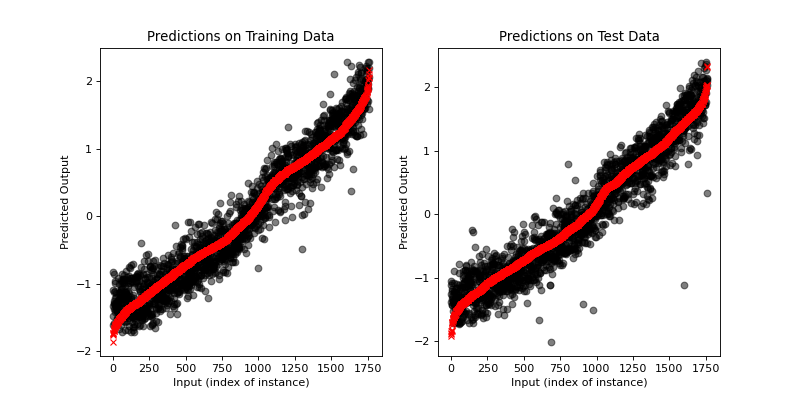

<IPython.core.display.Javascript object>


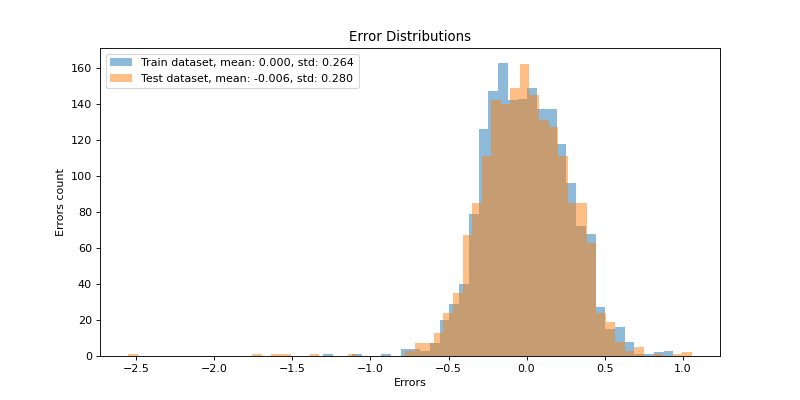

(<matplotlib.legend.Legend at 0x22004c55700>,
 Text(0.5, 1.0, 'Error Distributions'))

In [94]:
# plot predictions and historgrams of errors (show the model is has uniform errors)
def plot_model_predictions_vs_y_data(target_output : np.ndarray, model_output : np.ndarray, ax, plt_info : dict):
    sorting_permutation = sorted(range(model_output.shape[0]), key=lambda k: model_output[k])
    ax.plot(target_output[sorting_permutation], 'ko', alpha=0.5)
    ax.plot(model_output[sorting_permutation], 'rx')

    ax.set_xlabel('Input (index of instance)')
    ax.set_ylabel('Predicted Output')
    ax.set_title(plt_info['title'])

def plot_error_distributions(target_output : np.ndarray, model_output : np.ndarray, ax, plt_info : dict):
    errors = target_output - model_output
    label = f"{plt_info['dataset']} dataset, mean: {errors.mean():.3f}, std: {errors.std():.3f}"
    ax.hist(errors, bins='auto', alpha=0.5, label=label)
    ax.set_xlabel('Errors')
    ax.set_ylabel('Errors count')

# Plot model predictions vs true outputs
fig, axes = plt.subplots(1, 2, figsize=(10,5))
plot_model_predictions_vs_y_data(y_train, predictions_train, axes[0], {'title': 'Predictions on Training Data'})
plot_model_predictions_vs_y_data(y_test, predictions_test, axes[1], {'title': 'Predictions on Test Data'})

# Plot error distributions
fig, axes = plt.subplots(1, 1, figsize=(10,5))
plot_error_distributions(y_train, predictions_train, axes, {'dataset': 'Train'})
plot_error_distributions(y_test, predictions_test, axes, {'dataset': 'Test'})
axes.legend(), axes.set_title('Error Distributions')


**TO DO 7**: Answer in ths cell (you do not need more than 5-7 lines):

1- What is the intuition behind the definition of COD, would you prefer it high or low?

2- What results have been achieved using the linear model in this dataset (compare the metrics we used both on 
    training and test datasets). Is this what you expected? Is this a good model to describe the dataset?

3- Compare the output prediction and the distributions of errors (this plot might be the clearest), 
    what do you observe? 

In [95]:
# YOUR CODE HERE
#    
#   1- It sais to us what is the correlation that exist between the error on our predictions and the distance of labels
#      from the mean; we want it nearest as possible to one. In this way there is a linear correlation between the two mentioned
#      term
#
#   2- Yes, i think that the model described by the training dataset is a good model because the evaluation
#      that we can do with respect to its metrics is very similar to the metrics evaluated on the test dataset. 
#      Therefore the samples that we used for construct our predictions are good rappresentants of the real model
#
#   3- I Observe that in both cases, with train and test dataset, our probability distribution of errors are very similar and 
#      their corrispective mean are very near to zero. This is an evidence about the good choice of use a linear function 
#      to rappresent our real model.

## Confidence intervals for output predictions
In the following we will use d to represent the number of paraemters of the linear model (which may contain the bias b).

Having estimated the extended set of coefficients $\hat w$ (remember this is the outcome of a random variable), and given a new location $x_0$, the output prediction  has the form
$$
\hat y_0 : = x_0 ^\top \hat w
$$
and postulating $X^T X$ is invertible and that 
$$
y_0 = x_0^\top w + \epsilon_0 \quad \epsilon_0 \sim {\cal N}(0,\sigma^2)
$$
where $w := \mathbb{E}[\hat{w}]$ (due to the invertibility assumption). You can think the last assumption is not that far from being true: remember the bell shaped errors we plotted before (very very close to be a gaussian)! We would like to compute a confidence interval on the output prediction or equivalently for the estimation error
$$
\tilde y_0:=\hat y_0 - y_0$$
Using the equations above we have that 
$$
\tilde y_0 =x_0^\top (\hat w - w) -  \epsilon_0
$$
where $\epsilon_0$ and $\hat w$ are uncorrelated (since $x_0$ is a new input location $\hat{w}$ does not depend on $x_0$). It thus follows that ($x_0$ is a deterministic quantity)
$$
\tilde y_0 \sim {\cal N}(0, x_0^\top {Var}\{\hat w\}x_0  + \sigma^2)
$$
where
$$
x_0^\top {Var}\{\hat w\}x_0 = \sigma^2 x_0^T (X^TX)^{-1}x_0 \quad \quad
$$
Try to compute the variance of the random variable $\hat w$ (write its equation and then substitute $Y = Xw + E$ with $E\sim \mathcal N (0, \sigma^2 I)$).

__Note__: We do not know $\sigma^2$, we must estimate it from the data!

Using the results we have seen in class (extended to the case of unknown variance) we have that the interval 
$$
[ - \Delta_0, + \Delta_0] \quad \quad \Delta_0 : = \hat\sigma \, t_{1-\frac{\alpha}{2}}(m_{t}-d-1) \sqrt{x_0^\top (X^\top X)^{-1}x_0 + 1} 
$$
where 
$$
\hat\sigma^2:= \frac{1}{m_t-d-1}\sum_{i\in S_t} (y_i - \hat w^\top x_i)^2
$$
satisfies the condition
$$
\mathbb{P}[\tilde y_0 \in [ - \Delta_0, + \Delta_0]] =\mathbb{P}[\hat  y_0 - y_0 \in [ - \Delta_0, + \Delta_0]]= 1-\alpha
$$
Equivalently we can write
$$
\mathbb{P}[y_0 \in [ \hat y_0- \Delta_0,  \hat y_0 + \Delta_0]]  = 1-\alpha
$$
Note that in the latter equation both $y_0$ AND the interval $[ \hat y_0- \Delta_0,  \hat y_0 + \Delta_0]$ are random. The probability is to be understood with repect to both the choice of the traning set $(Y,X)$  as well as on the choice of $y_0$. 
With some abuse of terminology we shall say that $[ \hat y_0- \Delta_0,  \hat y_0 + \Delta_0]$ is a confidence interval of level $1-\alpha$ for $y_0$.

In [96]:
# TODO8: Compute confidence intervals for output prediction of the linear model on the test dataset

# Get t_percentile from scipy.stats
from scipy.stats import t
alpha = 0.05
t_percentile = 0 # replace with the correct value of the percentile
# YOUR CODE HERE
t_percentile = t.interval(1-alpha, m_t-x_train.shape[1], 0, 1)
# Estimate sigma_2_hat
sigma_2_hat = 0 # replace with the correct value of the estimate
# YOUR CODE HERE
sigma_2_hat=(1/(m_t-x_train.shape[1]-1))*rss(y_train, linear_predictions(w_hat,x_train))
# In this case X^TX is invertible, therefore the pseudoinverse and the inverse are exatly the same.
# Do not forget to add the column of ones to the dataset you are going to use but do not overwrite them! 
# Use the variable ci_O to save the output confidence intervals
# YOUR CODE HERE
x_1=np.ones((x_test.shape[0],1))
x_2=np.ones((x_train.shape[0],1))#column of one
x_data_extended_test=np.hstack((x_test, x_1))
x_data_extended_train=np.hstack((x_train, x_2))
for i in range((x_data_extended_train.shape[0])):
    radix=(np.matmul(np.matmul(x_data_extended_test[i:i+1],np.linalg.inv(np.matmul(x_data_extended_train.T,x_data_extended_train))),x_data_extended_test[i:i+1].T))+1
delta_zero_positive=(sigma_2_hat**(1/2))*t_percentile[1]*(radix**(1/2))
delta_zero_negative=(sigma_2_hat**(1/2))*t_percentile[0]*(radix**(1/2))
delta_zero=[delta_zero_positive, delta_zero_negative]
ci_O=np.zeros((x_test.shape[0], 2))
for i in range(x_data_extended_train.shape[0]):
    for j in range(ci_O.shape[1]):
         ci_O[i][j]=linear_predictions(w_hat,x_test[i:i+1])+delta_zero[j]
print(f"These are the output confidence intervals \n {ci_O} \n of shape {ci_O.shape}")

These are the output confidence intervals 
 [[ 1.27905008  0.23934389]
 [ 1.99363327  0.95392708]
 [ 0.96805546 -0.07165074]
 ...
 [ 1.61012294  0.57041675]
 [ 1.86459461  0.82488842]
 [ 0.          0.        ]] 
 of shape (1761, 2)


In [97]:
assert x_train.shape[1] == w_hat.shape[0] - 1
assert x_test.shape[1] == w_hat.shape[0] - 1
assert ci_O.shape[0] == x_test.shape[0]
assert ci_O.shape[1] == 2


<IPython.core.display.Javascript object>


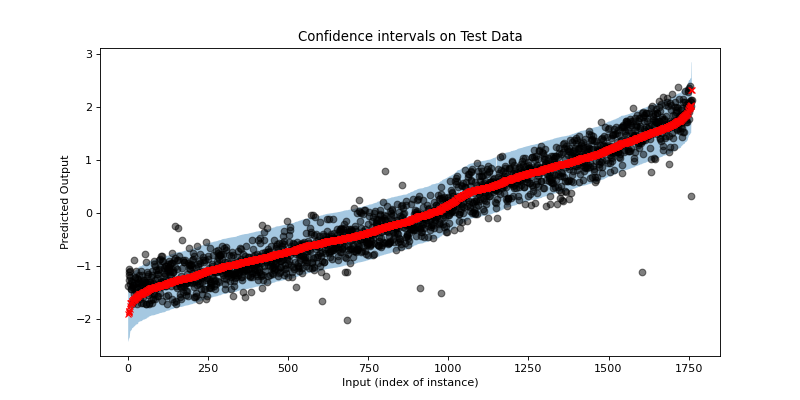

In [98]:
def plot_model_predictions_vs_CI(target_output : np.ndarray, model_output : np.ndarray, c_i : np.ndarray, ax, 
                                 plt_info : dict):
    sorting_permutation = sorted(range(model_output.shape[0]), key=lambda k: model_output[k])
    ax.plot(target_output[sorting_permutation], 'ko', alpha=0.5)
    ax.plot(model_output[sorting_permutation], 'rx')
    ax.fill_between(range(model_output.shape[0]), c_i[sorting_permutation,0], c_i[sorting_permutation,1], alpha=0.4)

    ax.set_xlabel('Input (index of instance)')
    ax.set_ylabel('Predicted Output')
    ax.set_title(plt_info['title'])

fig, ax = plt.subplots(1, 1, figsize=(10,5))
plot_model_predictions_vs_CI(y_test, predictions_test, ci_O, ax, {'title': 'Confidence intervals on Test Data'})


Why do we need the validation dataset? 
Up to now we have not used it! But up to now we have not tried to find the best hyper-parameters for our linear model.
Now we are going to find the best subset of features (and therefore the best coefficients) according to RSS or COD evaluated using the validation. 
In this very simple case we are going to use a brute force approach, we will try every single possible combination of features and evaluate the trained model using the validation dataset.

Since our model now depends on the validation dataset we should not use the validation dataset to evaluate the generalization capability of the new model, that is why we need a "new" dataset (that we have not used to optimize our model): the test dataset.

[(0,), (1,), (2,), (3,)]
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
[(0, 1, 2), (0, 1, 3), (0, 2, 3), (1, 2, 3)]
[(0, 1, 2, 3)]


<IPython.core.display.Javascript object>


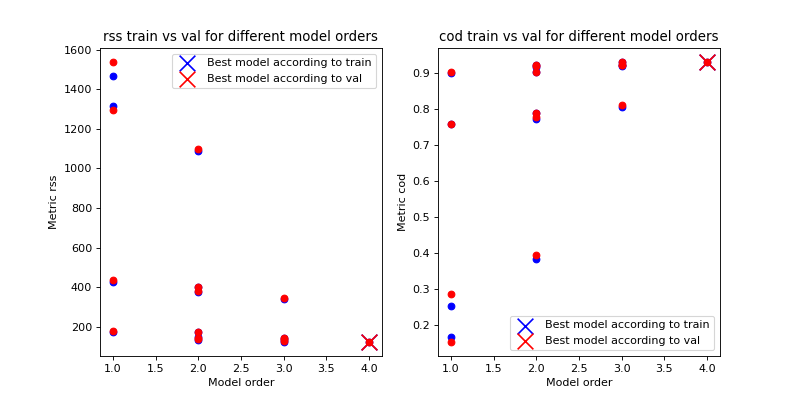

Test metrics for the best model: rss 138.2026, cod 0.9236


In [99]:
from itertools import combinations
from collections import defaultdict

# Let's use the functions we built up to now to find the best model order according the validation criterions.
# Once we choose the best model order, which is an hyper-parameters we will estimate its generalization
# capability using the test dataset! 

indexes_subset, train_metrics, val_metrics = [], defaultdict(list), defaultdict(list)
for k in range(1, x_train.shape[1] + 1):
    print(list(combinations(list(range(x_train.shape[1])), k)))
    all_combinations_given_k_choices = list(combinations(list(range(x_train.shape[1])), k))
    for indexes in all_combinations_given_k_choices:
        indexes_subset.append(indexes)
        x_train_subset, x_val_subset = x_train[:, indexes], x_val[:, indexes]
        w_hat = compute_LS_optimal_ERM_coefficients(x_train_subset, y_train)
        # Predict Training metrics
        predictions_train = linear_predictions(w_hat, x_train_subset)
        rss_hand_train, cod_hand_train = rss(y_train, predictions_train), cod(y_train, predictions_train)
        train_metrics['rss'].append(rss_hand_train)
        train_metrics['cod'].append(cod_hand_train)
        # Predict Generalization metrics (using the validation set)
        predictions_val = linear_predictions(w_hat, x_val_subset)
        rss_hand_val, cod_hand_val = rss(y_val, predictions_val), cod(y_val, predictions_val)
        val_metrics['rss'].append(rss_hand_val)
        val_metrics['cod'].append(cod_hand_val)   

# Let's find which is the best model according to the validation error 
def plot_metric_vs_model_order(indexes_subset, metric_results, ax, plot_info):
    for indexes, metric in zip(indexes_subset, metric_results):
        ax.scatter(len(indexes), metric, color=plot_info['color'])
    # Find best model 
    best_index = np.argmax(metric_results) if plot_info['metric'] == 'cod' else np.argmin(metric_results)
    ax.scatter(len(indexes_subset[best_index]), metric_results[best_index], color=plot_info['color'], marker='x', 
               s=200, label=f"Best model according to {plot_info['dataset']}")

    ax.set_xlabel('Model order')
    ax.set_ylabel(f"Metric {plot_info['metric']}")
    ax.set_title(f"{plot_info['metric']} train vs val for different model orders")
    ax.legend()
    return indexes_subset[best_index]
    
fig, axes = plt.subplots(1,2, figsize=(10, 5))
# RSS metric
plot_metric_vs_model_order(indexes_subset, train_metrics['rss'], axes[0], 
                           {'color': 'blue', 'dataset': 'train', 'metric': 'rss'})
best_features_subset = plot_metric_vs_model_order(indexes_subset, val_metrics['rss'], axes[0], 
                           {'color': 'red', 'dataset': 'val', 'metric': 'rss'})
# COD metric
plot_metric_vs_model_order(indexes_subset, train_metrics['cod'], axes[1], 
                           {'color': 'blue', 'dataset': 'train', 'metric': 'cod'})
plot_metric_vs_model_order(indexes_subset, val_metrics['cod'], axes[1], 
                           {'color': 'red', 'dataset': 'val', 'metric': 'cod'})

# We now evaluate the best model (you can choose if you prefer COD or RSS as criterion) on the test dataset
predictions_test_best = linear_predictions(w_hat, x_test[:,best_features_subset])
rss_hand_test_best, cod_hand_test_best = rss(y_test, predictions_test_best), cod(y_test, predictions_test_best)
print(f"Test metrics for the best model: rss {rss_hand_test_best:.4f}, cod {cod_hand_test_best:.4f}")

In this last part of the HW we will have a look at the running time of the methods we have written and compare them sklearn implementation. 
We are going to test what how the running time is increasing as a function of the number of data and the number of features we use in our linear model.

In [100]:
# Let's use a decorator to measure time 
running_times = defaultdict(list)

def measure_time(function):
    def wrap(*args, **kw):
        import time 
        t_start = time.time()
        result = function(*args, **kw)
        t_end = time.time()
        running_times[function.__name__].append(t_end - t_start)
        return result
    return wrap

# We should redefine the functions we already defined in order to apply the decortor, to avoid too many copy and paste
# let's wrap all the functions we are willing to compare.
@measure_time
def pseudoinverse_by_hand(A, threshold): 
    return pseudoinverse(A, threshold)

@measure_time
def LS_coeff_by_hand(x_train, y_train):
    return compute_LS_optimal_ERM_coefficients(x_train, y_train)

@measure_time
def LS_by_sklearn(x_train, y_train):
    w_hat_np, rss_np, _, _ = np.linalg.lstsq(x_train, y_train, rcond=None)

100it [01:12,  1.39it/s]


<IPython.core.display.Javascript object>


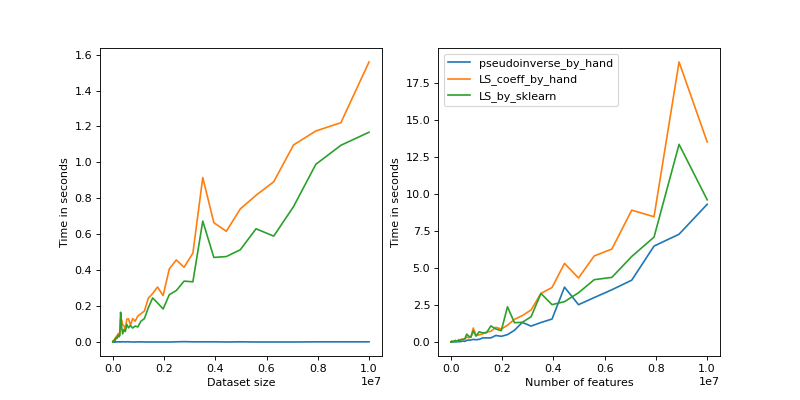

100it [04:09,  2.50s/it]


In [101]:
import tqdm 

def plot_time(name, times, traing_data_sizes, x_label, ax):
    ax.plot(traing_data_sizes, times, label=name)
    ax.set_ylabel('Time in seconds')
    ax.set_xlabel(x_label)

def plot_time_stats(x_label, ax):
    for f_name, function_times in running_times.items():
        plot_time(f_name, function_times, traing_data_sizes, x_label=x_label,ax=ax)
        running_times[f_name] = []

# Run functions and get times
traing_data_sizes = np.logspace(2,7, 100).astype(np.int64)
for i, m_t in tqdm.tqdm(enumerate(traing_data_sizes)):
    datasets = (np.random.normal(size=(m_t, 5)), np.random.normal(size=(m_t, 1)))
    # Let's call all the function we are willing to measure
    pseudoinverse_by_hand(np.matmul(datasets[0].T, datasets[0]), 1e-8)
    LS_coeff_by_hand(datasets[0], datasets[1])
    LS_by_sklearn(datasets[0], datasets[1])

fig, axes = plt.subplots(1,2, figsize=(10,5))
plot_time_stats('Dataset size', axes[0])

# Run functions and get times (you can try to change 3.3 to slightly higher numbers but the notebook will become slow)
traing_num_features = np.logspace(0, 3.3, 100).astype(np.int64)
for i, num_feat in tqdm.tqdm(enumerate(traing_num_features)):
    datasets = (np.random.normal(size=(10000, num_feat)), np.random.normal(size=(10000, 1)))
    # Let's call all the function we are willing to measure
    pseudoinverse_by_hand(np.matmul(datasets[0].T, datasets[0]), 1e-8)
    LS_coeff_by_hand(datasets[0], datasets[1])
    LS_by_sklearn(datasets[0], datasets[1])

plot_time_stats('Number of features', axes[1])
plt.legend() 

**TO DO 9**: Answer in the next cell (you do not need more than 5-7 lines):

1- What is the effect on running time due to the change in dataset size? Why?

2- What is the effect on running time due to the change in features size? Why?

3- What are the most time consuming computations we need to perform to compute the LS solution?  

YOUR ANSWER HERE 

1- we can observe that the time needed to execute the algorithm increase almost linearly with the size of dataset. However this
   trend isn't share by the function that calculate the pseudoinverse. This is the consequence of adding a number of rows equal
   to the number of new data. Adding rows doesn't change the rank of matrix X and, by definition, also the pseudo-inverse
   doesn't change.
   
2- In this case, for every new feature, we must add a columns in our matrix X. For this reason, the grow of the computational
   time is faster than the same considering the increasing of size of data. In this case, the rank of the matrix X, defined by
   the number of linear independent columns, grow with the number of features considered. The time needed for compute the
   pseudo-inverse increase and rappresent an important fraction of the total computation time.
   
3- The most time consuming operation to perform into the LS solution is the evalutation of the pseudo-inverse.